Now that we have a collection of information extracted from Staff Profile pages for CDI members and have done a little bit of work aligning terms with the USGS Thesaurus, we can take a look at the information through a number of slices and think about implications. This notebook grabs up our data on terms and preps a number of lists for examination.

In [1]:
%matplotlib inline
import requests
from sqlite_utils import Database
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

db = Database("usgs_profiles.db")

In [2]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
def similar_terms(target_term, term_list, threshold=0.5, lower_case=False):
    term_list = [i for i in term_list if i != target_term]

    if lower_case:
        term_list = [i.lower() for i in term_list]

    doc_vectors = TfidfVectorizer().fit_transform([target_term] + term_list)
    cosine_similarities = linear_kernel(doc_vectors[0:1], doc_vectors).flatten()
    document_scores = [item.item() for item in cosine_similarities[1:]]
    similar_list = [term_list[index] for index, score in enumerate(document_scores) if score > threshold]

    return similar_list

Here, I group the expertise terms into several distinct categories for each uniquely identified person based on their Staff Profile URL as the identifier. Now that we have this information in the ScienceBase Directory, we can get through from that URL to further details and other identifiers. But for this exercise, the staff profile URL is good enough. Putting the terms together this way lets me assemble lists for frequency counting and visualization.

In [3]:
expertise_data = [i for i in db["expertise_terms"].rows]
profile_expertise = list()
for profile in list(set([i["source_identifier"] for i in expertise_data])):
    profile_expertise.append({
        "profile": profile,
        "user_supplied_terms": list(
            set(
                [
                    i["term"].lower() for i in expertise_data 
                    if i["source_identifier"] == profile 
                    and i["term_source"] == "USGS Staff Profiles"
                ]
            )
        ),
        "usgs_thesaurus_aligned_terms": list(
            set(
                [
                    i["term"].lower() for i in expertise_data 
                    if i["source_identifier"] == profile 
                    and i["term_source"] == "USGS Thesaurus Exact Match from Staff Profile"
                ]
            )
        ),
        "usgs_thesaurus_all_terms": list(
            set(
                [
                    i["term"].lower() for i in expertise_data 
                    if i["source_identifier"] == profile 
                    and i["term_source"] in [
                        "USGS Thesaurus Exact Match from Staff Profile",
                        "USGS Thesaurus Suggested Terms from Staff Profile"
                    ]
                ]
            )
        ),
        "all_terms": list(
            set(
                [
                    i["term"].lower() for i in expertise_data 
                    if i["source_identifier"] == profile 
                    and i["term_source"] in [
                        "USGS Staff Profiles",
                        "USGS Thesaurus Exact Match from Staff Profile",
                        "USGS Thesaurus Suggested Terms from Staff Profile"
                    ]
                ]
            )
        ),
    })
    
user_supplied_terms = list()
usgs_thesaurus_aligned_terms = list()
usgs_thesaurus_all_terms = list()
all_terms = list()
for item in profile_expertise:
    user_supplied_terms.extend(item["user_supplied_terms"])
    usgs_thesaurus_aligned_terms.extend(item["usgs_thesaurus_aligned_terms"])
    usgs_thesaurus_all_terms.extend(item["usgs_thesaurus_all_terms"])
    all_terms.extend(item["all_terms"])
non_thesaurus_terms = [i for i in all_terms if i not in usgs_thesaurus_all_terms]
all_terms.sort()
shared_expertise = [(item,count) for item, count in Counter(all_terms).items() if count > 1]
unique_expertise = [item for item, count in Counter(user_supplied_terms).items() if count == 1]

## User Supplied Terms
This word cloud looks just at the frequency of terms supplied directly by users regardless of their alignment with the USGS Thesaurus.

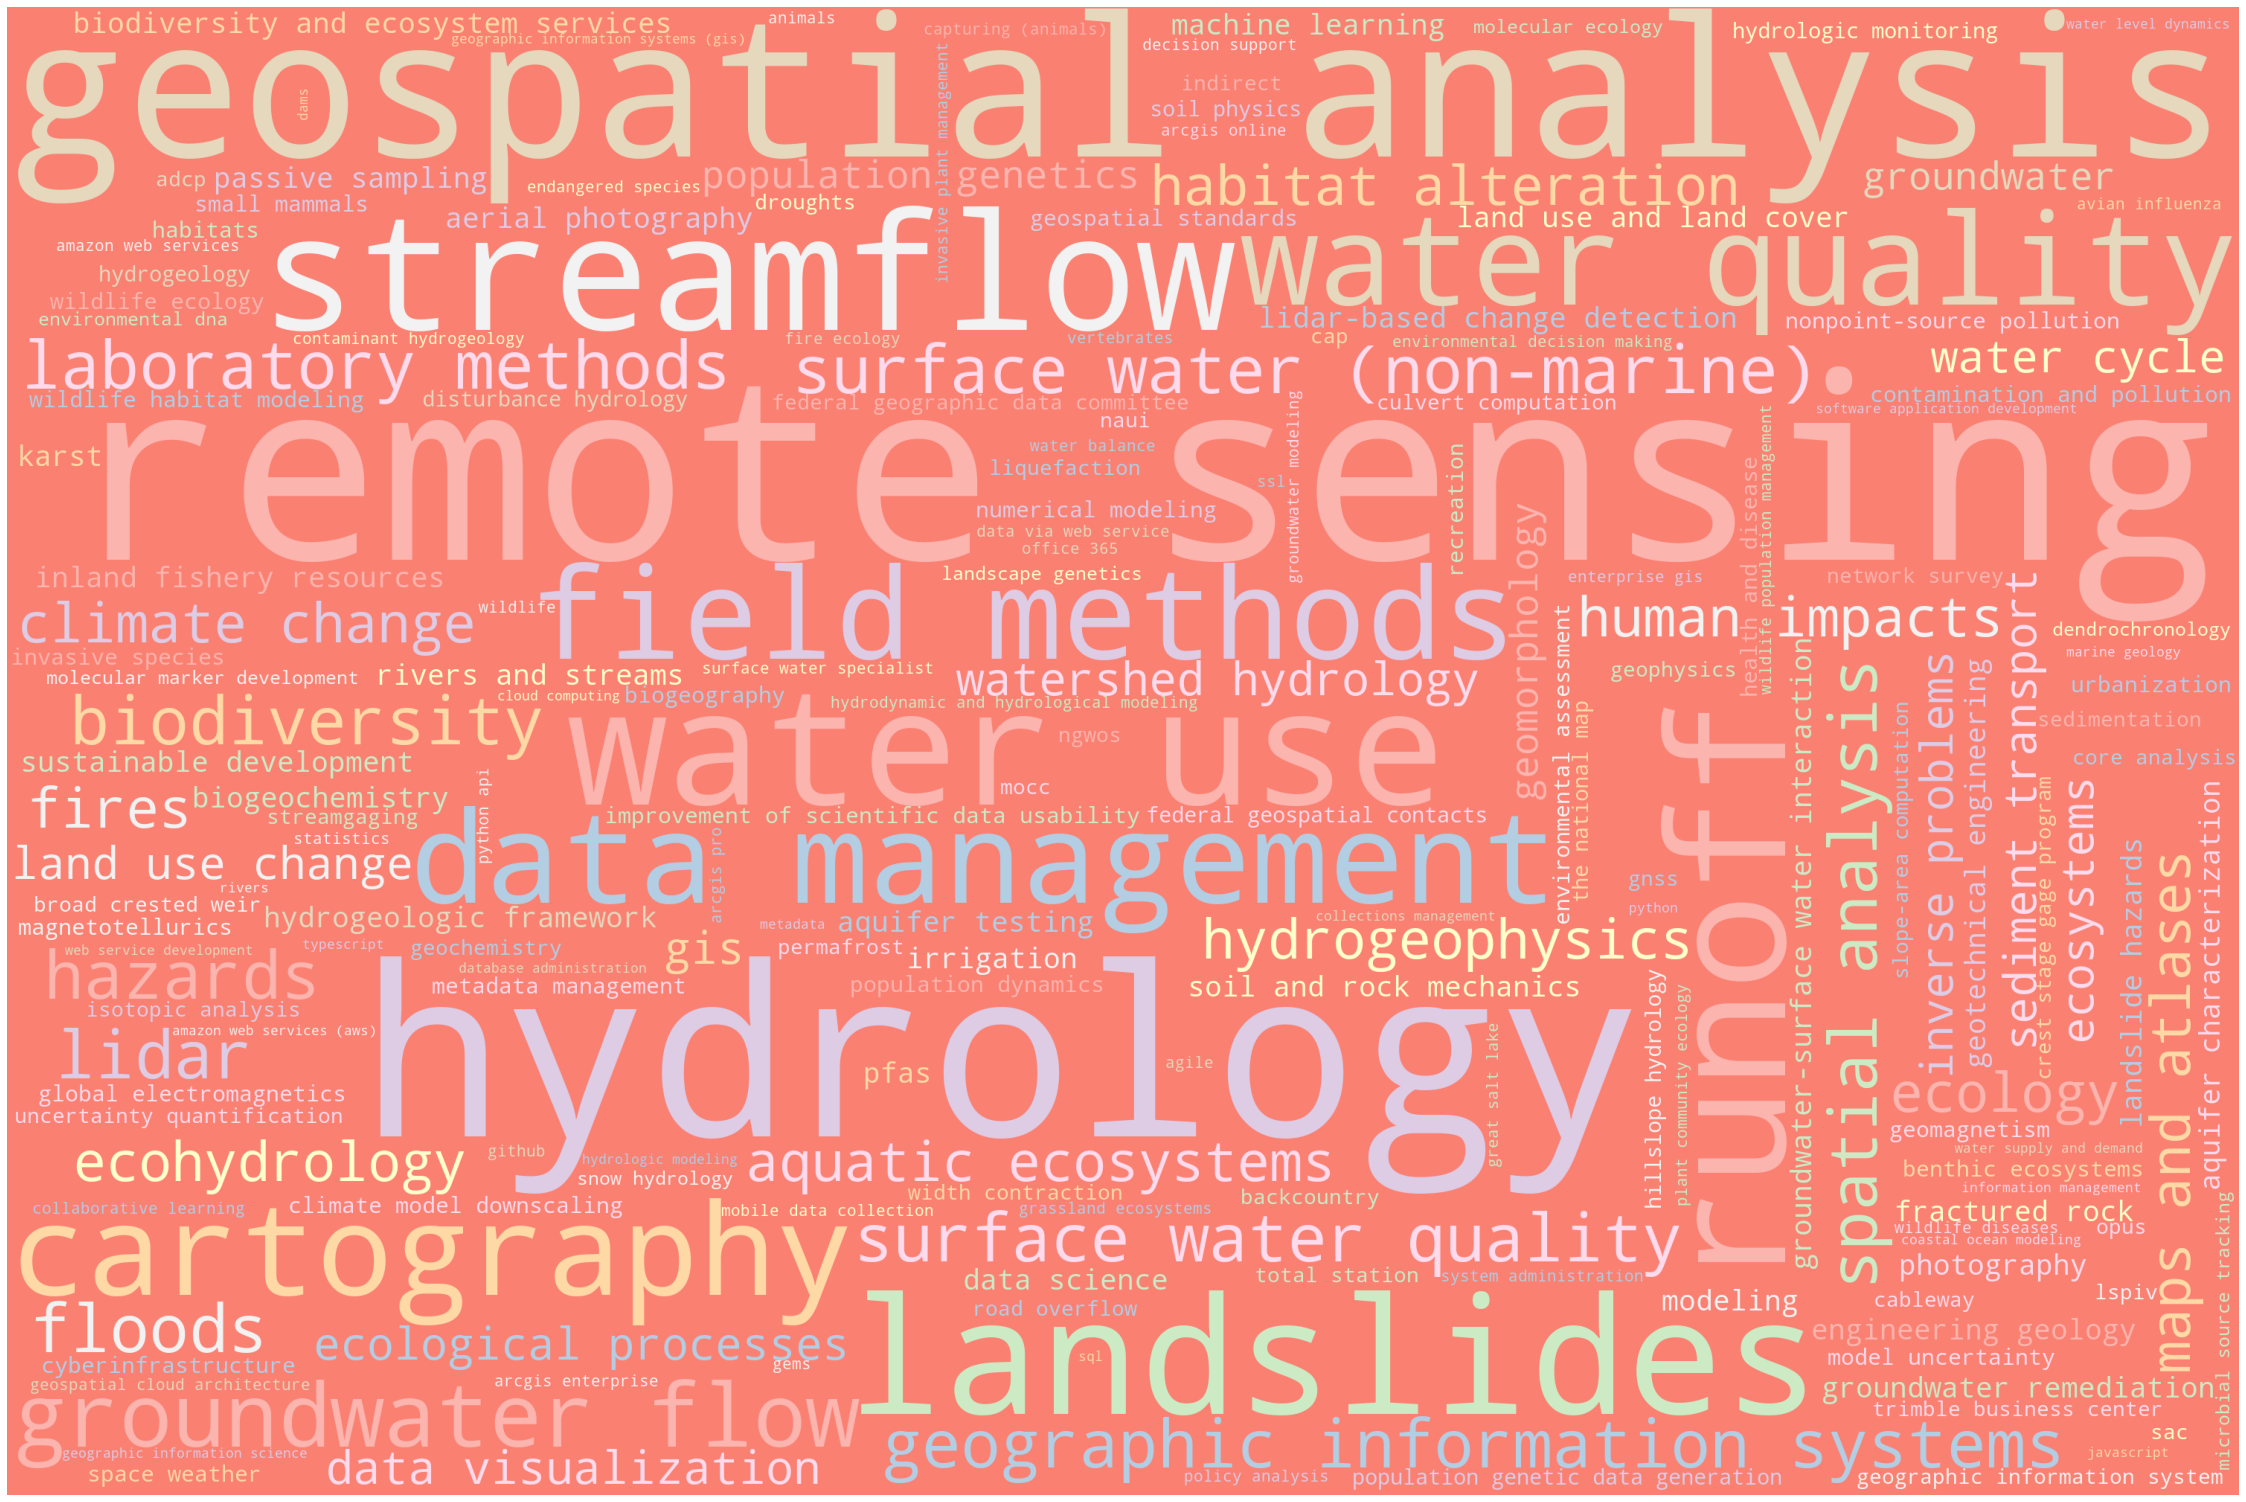

In [4]:
wordcloud_user_supplied_terms = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate_from_frequencies(Counter(user_supplied_terms))

plot_cloud(wordcloud_user_supplied_terms)

## Terms aligned exactly with USGS Thesaurus
This word cloud looks at the frequency of terms supplied by users that we were able to directly match to the USGS Thesaurus.

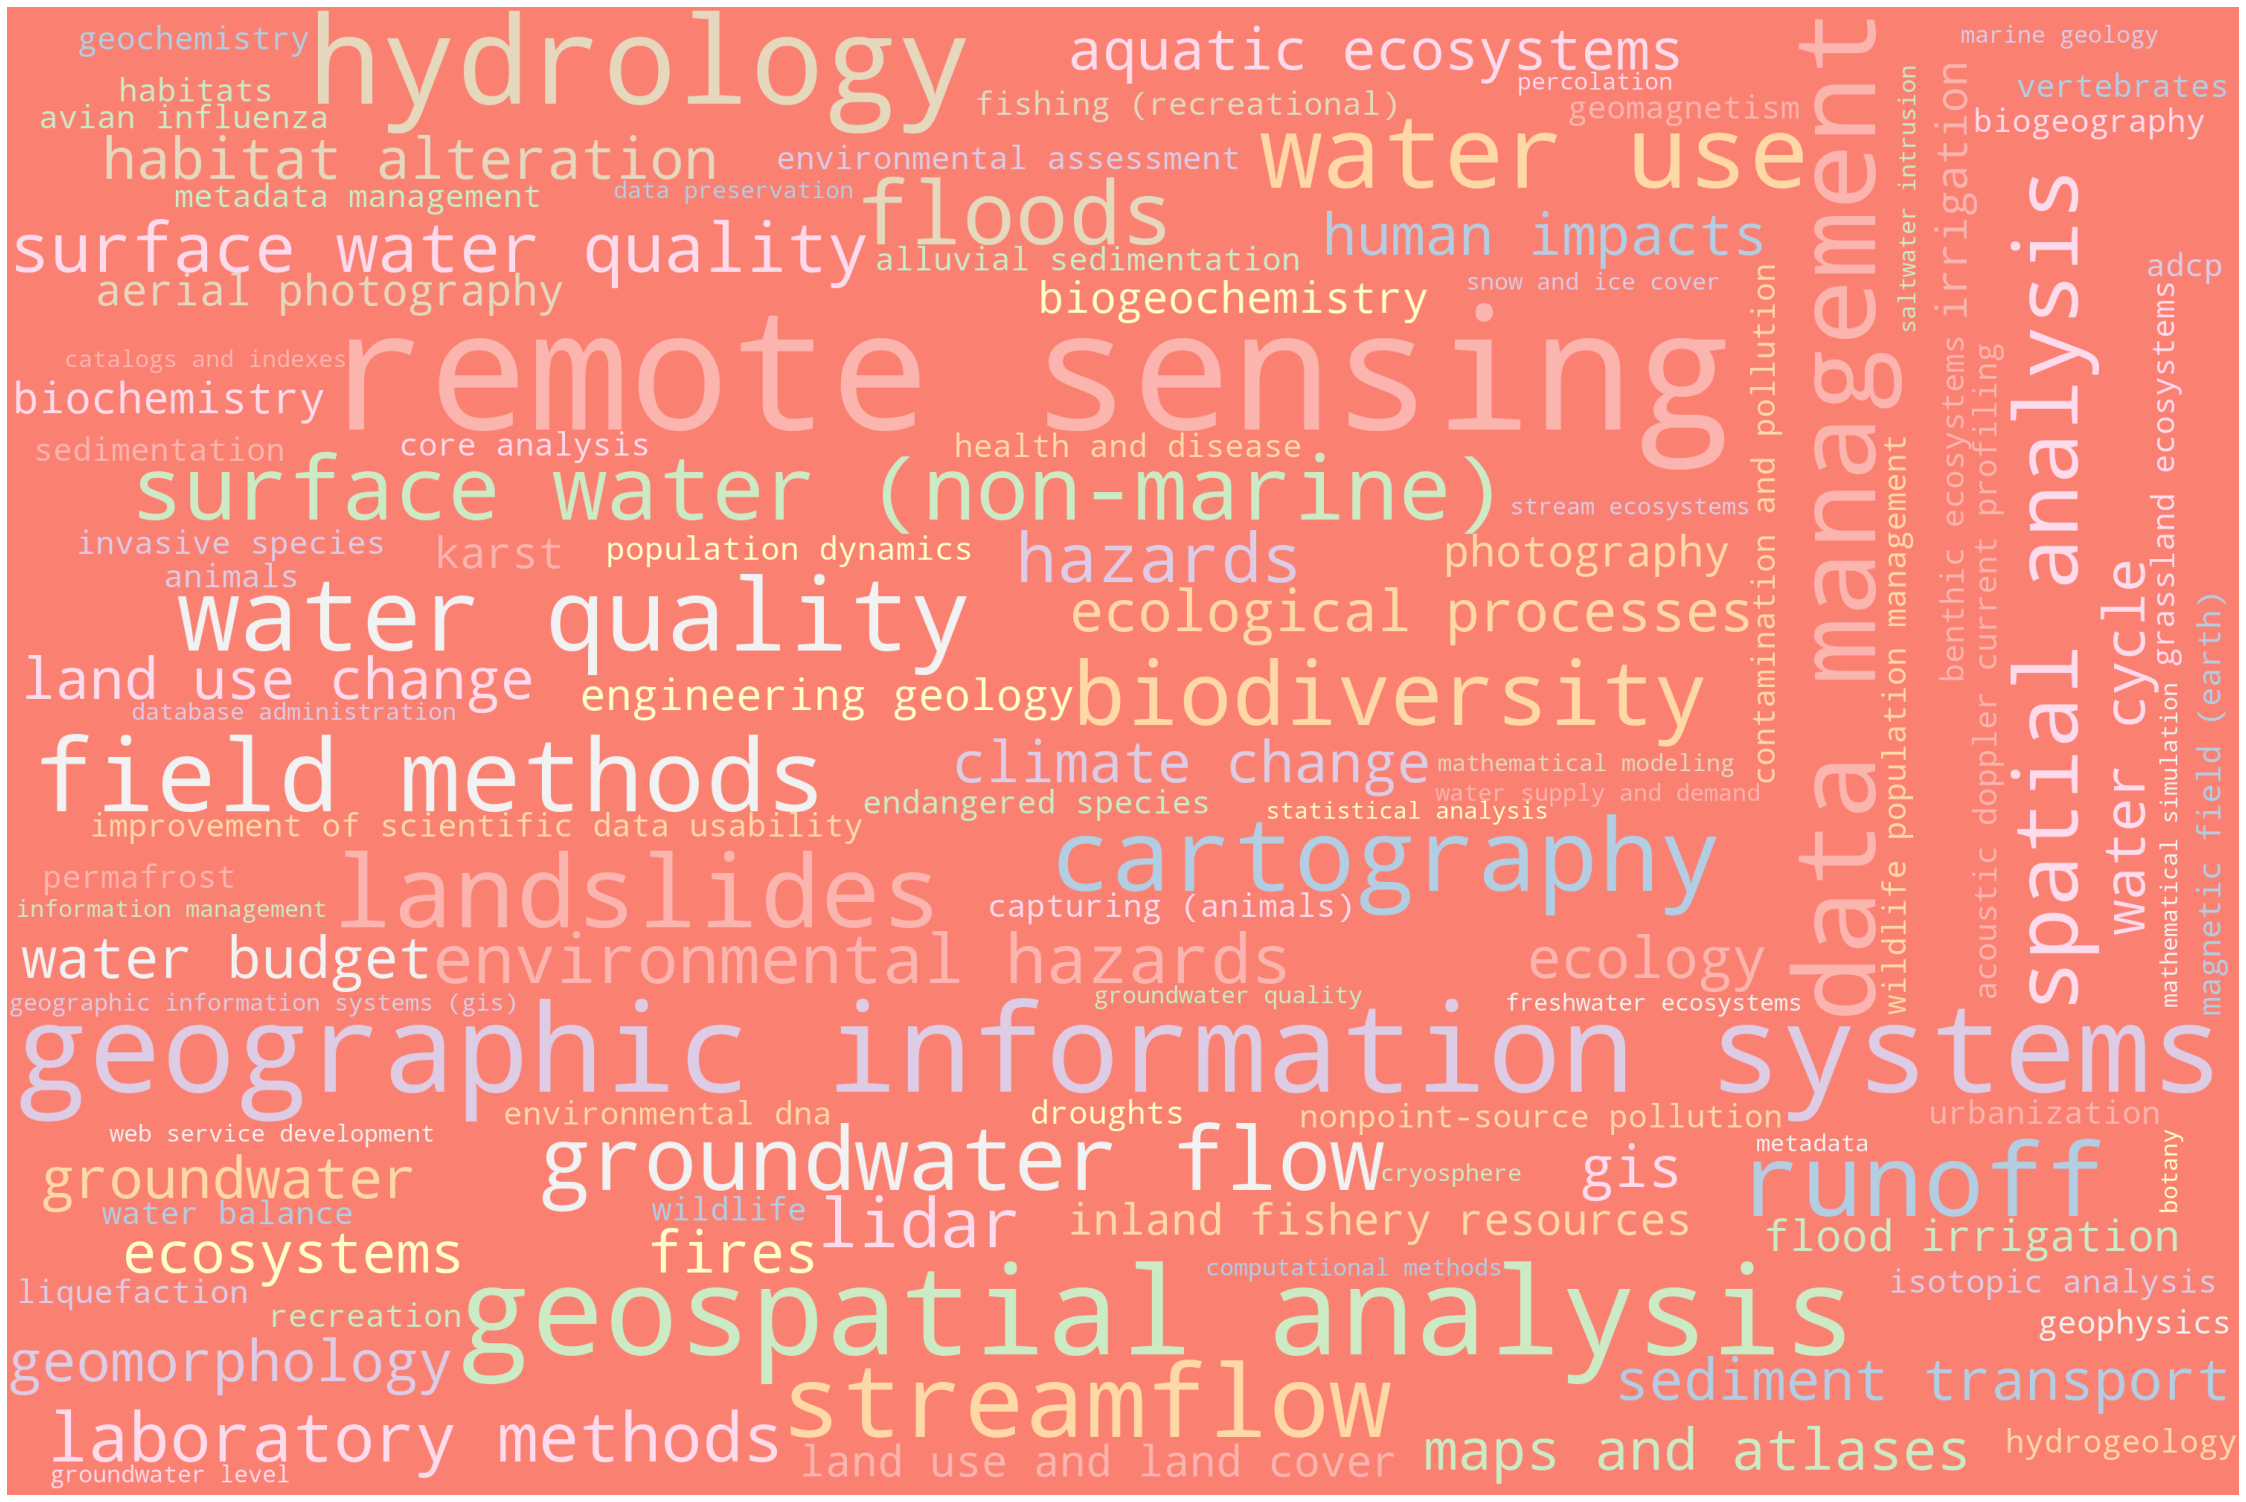

In [5]:
wordcloud_usgs_thesaurus_aligned_terms = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate_from_frequencies(Counter(usgs_thesaurus_aligned_terms))

plot_cloud(wordcloud_usgs_thesaurus_aligned_terms)

## All Thesaurus Terms
This word cloud looks at the frequency of terms supplied by users that we were able to match to the USGS Thesaurus, including those that are only possibly related to the term supplied by the profile owners.

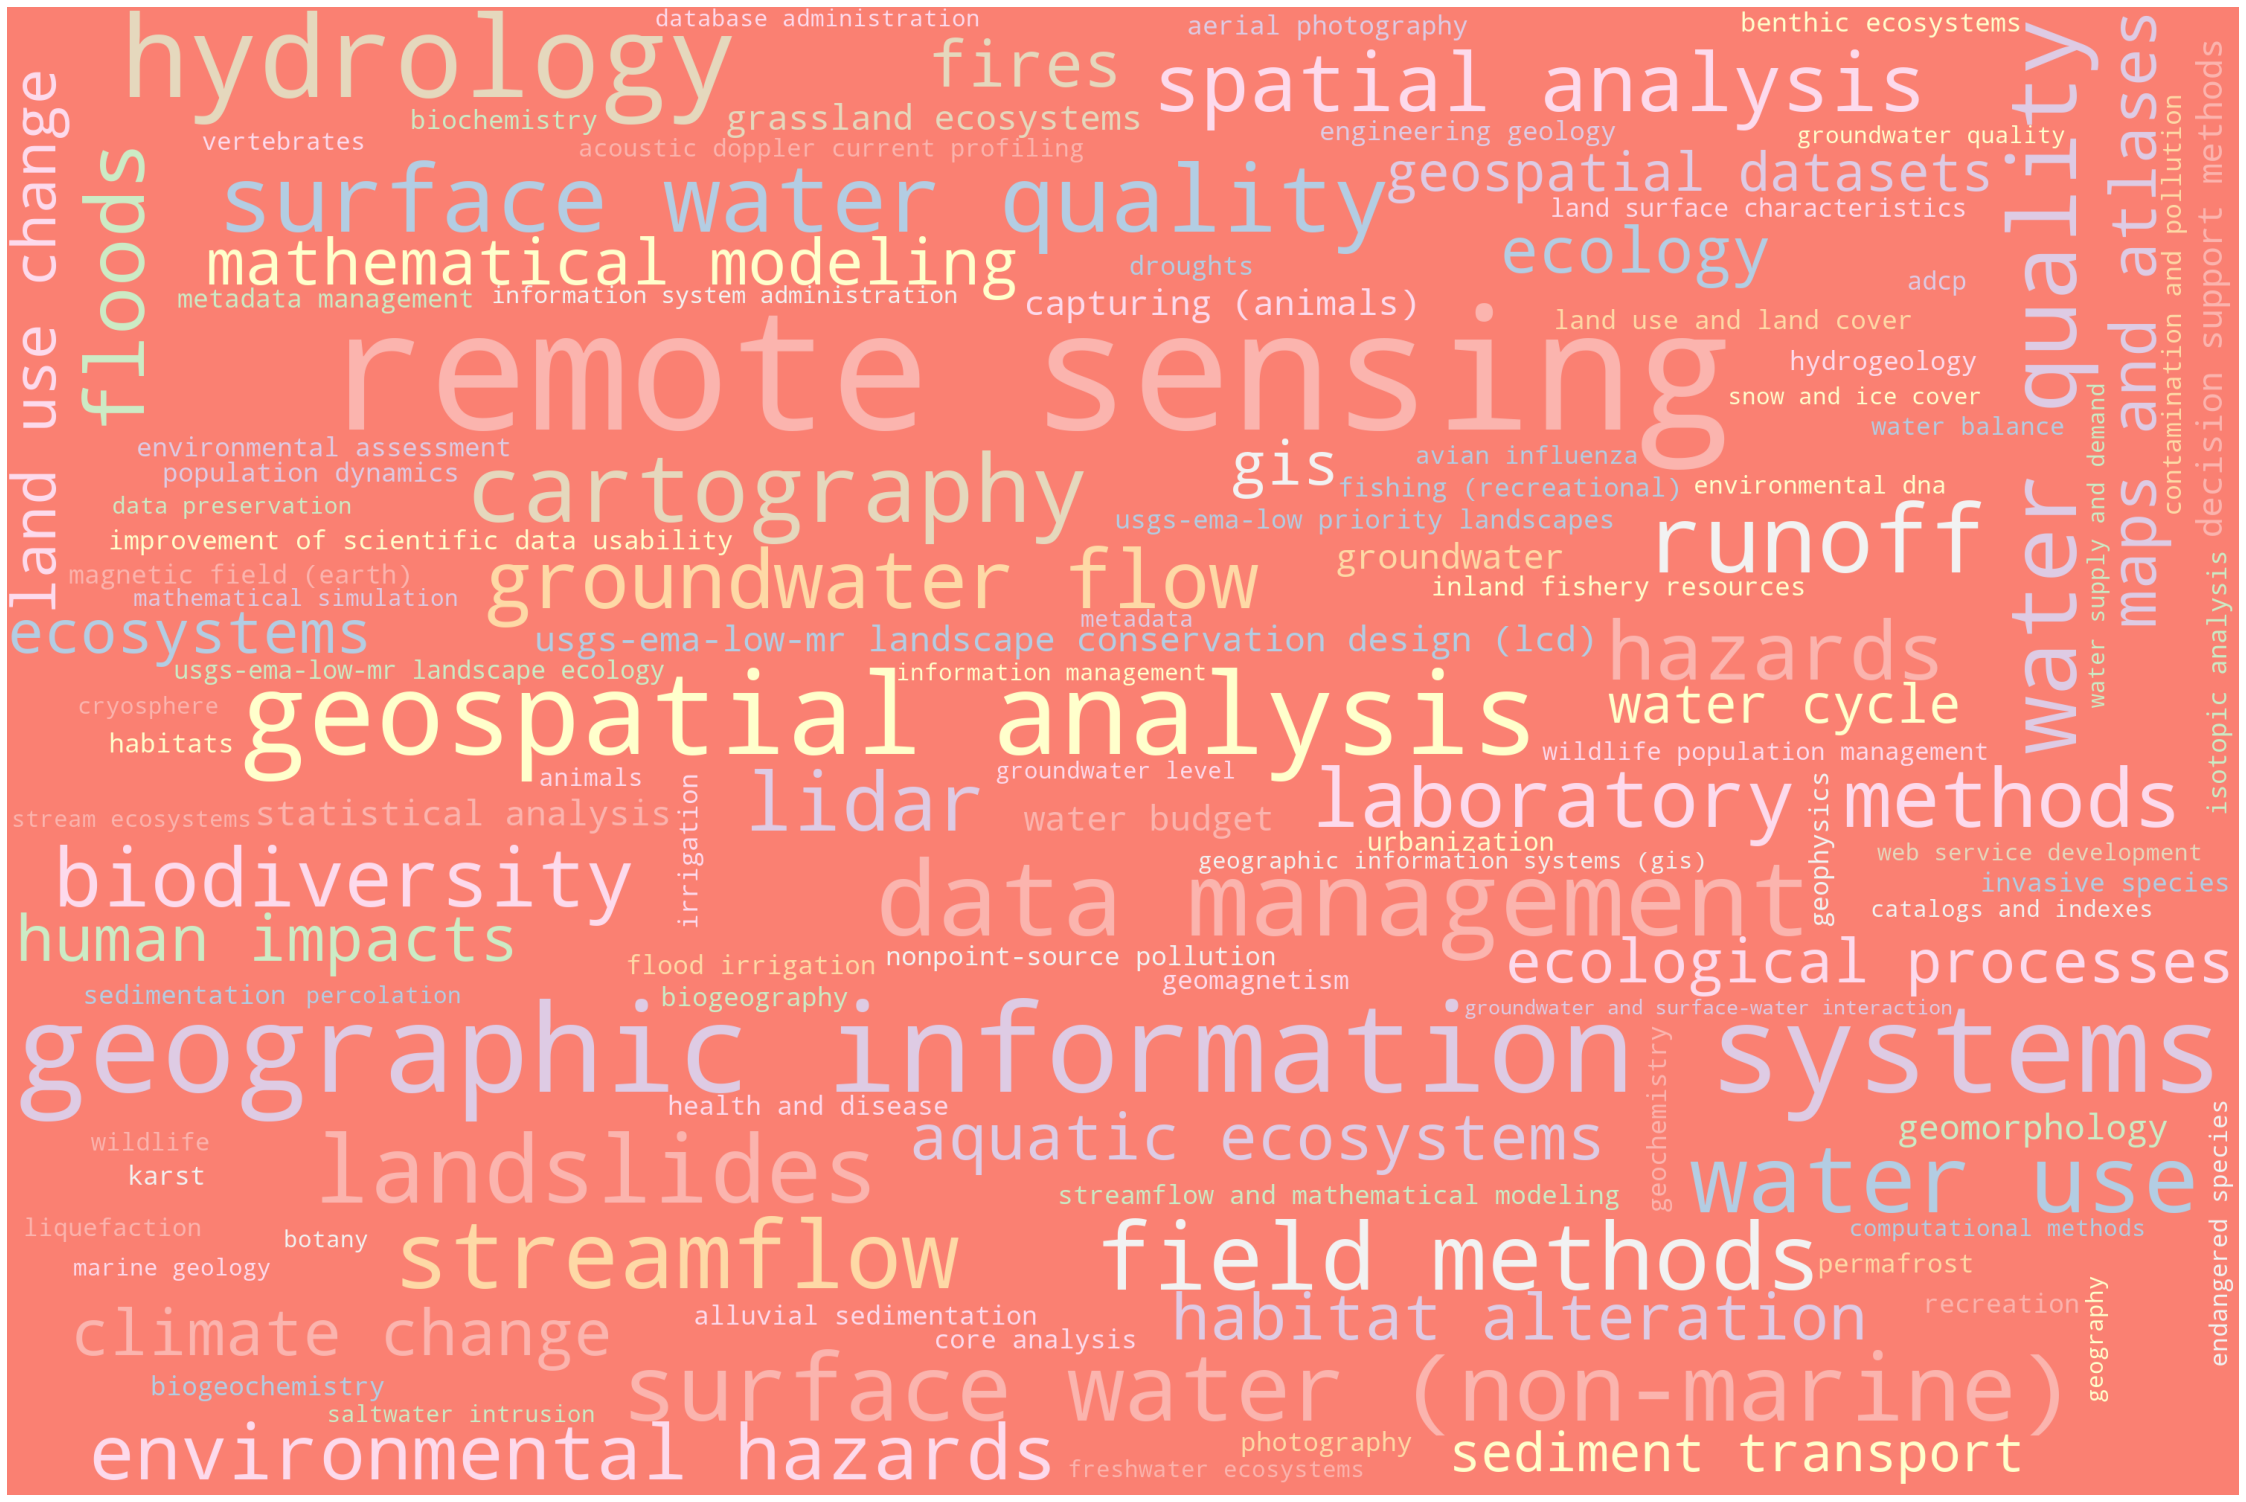

In [6]:
wordcloud_usgs_thesaurus_all_terms = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate_from_frequencies(Counter(usgs_thesaurus_all_terms))

plot_cloud(wordcloud_usgs_thesaurus_all_terms)

## All Terms
This word cloud looks the frequency of all terms, including those supplied by users and those suggested as matches from the USGS Thesaurus. This branches out slightly from user-supplied terms to those where the USGS Thesaurus suggests different labels. However, it does not delve into preferred terms or other possible refinement on topics that the USGS Thesaurus could facilitate.

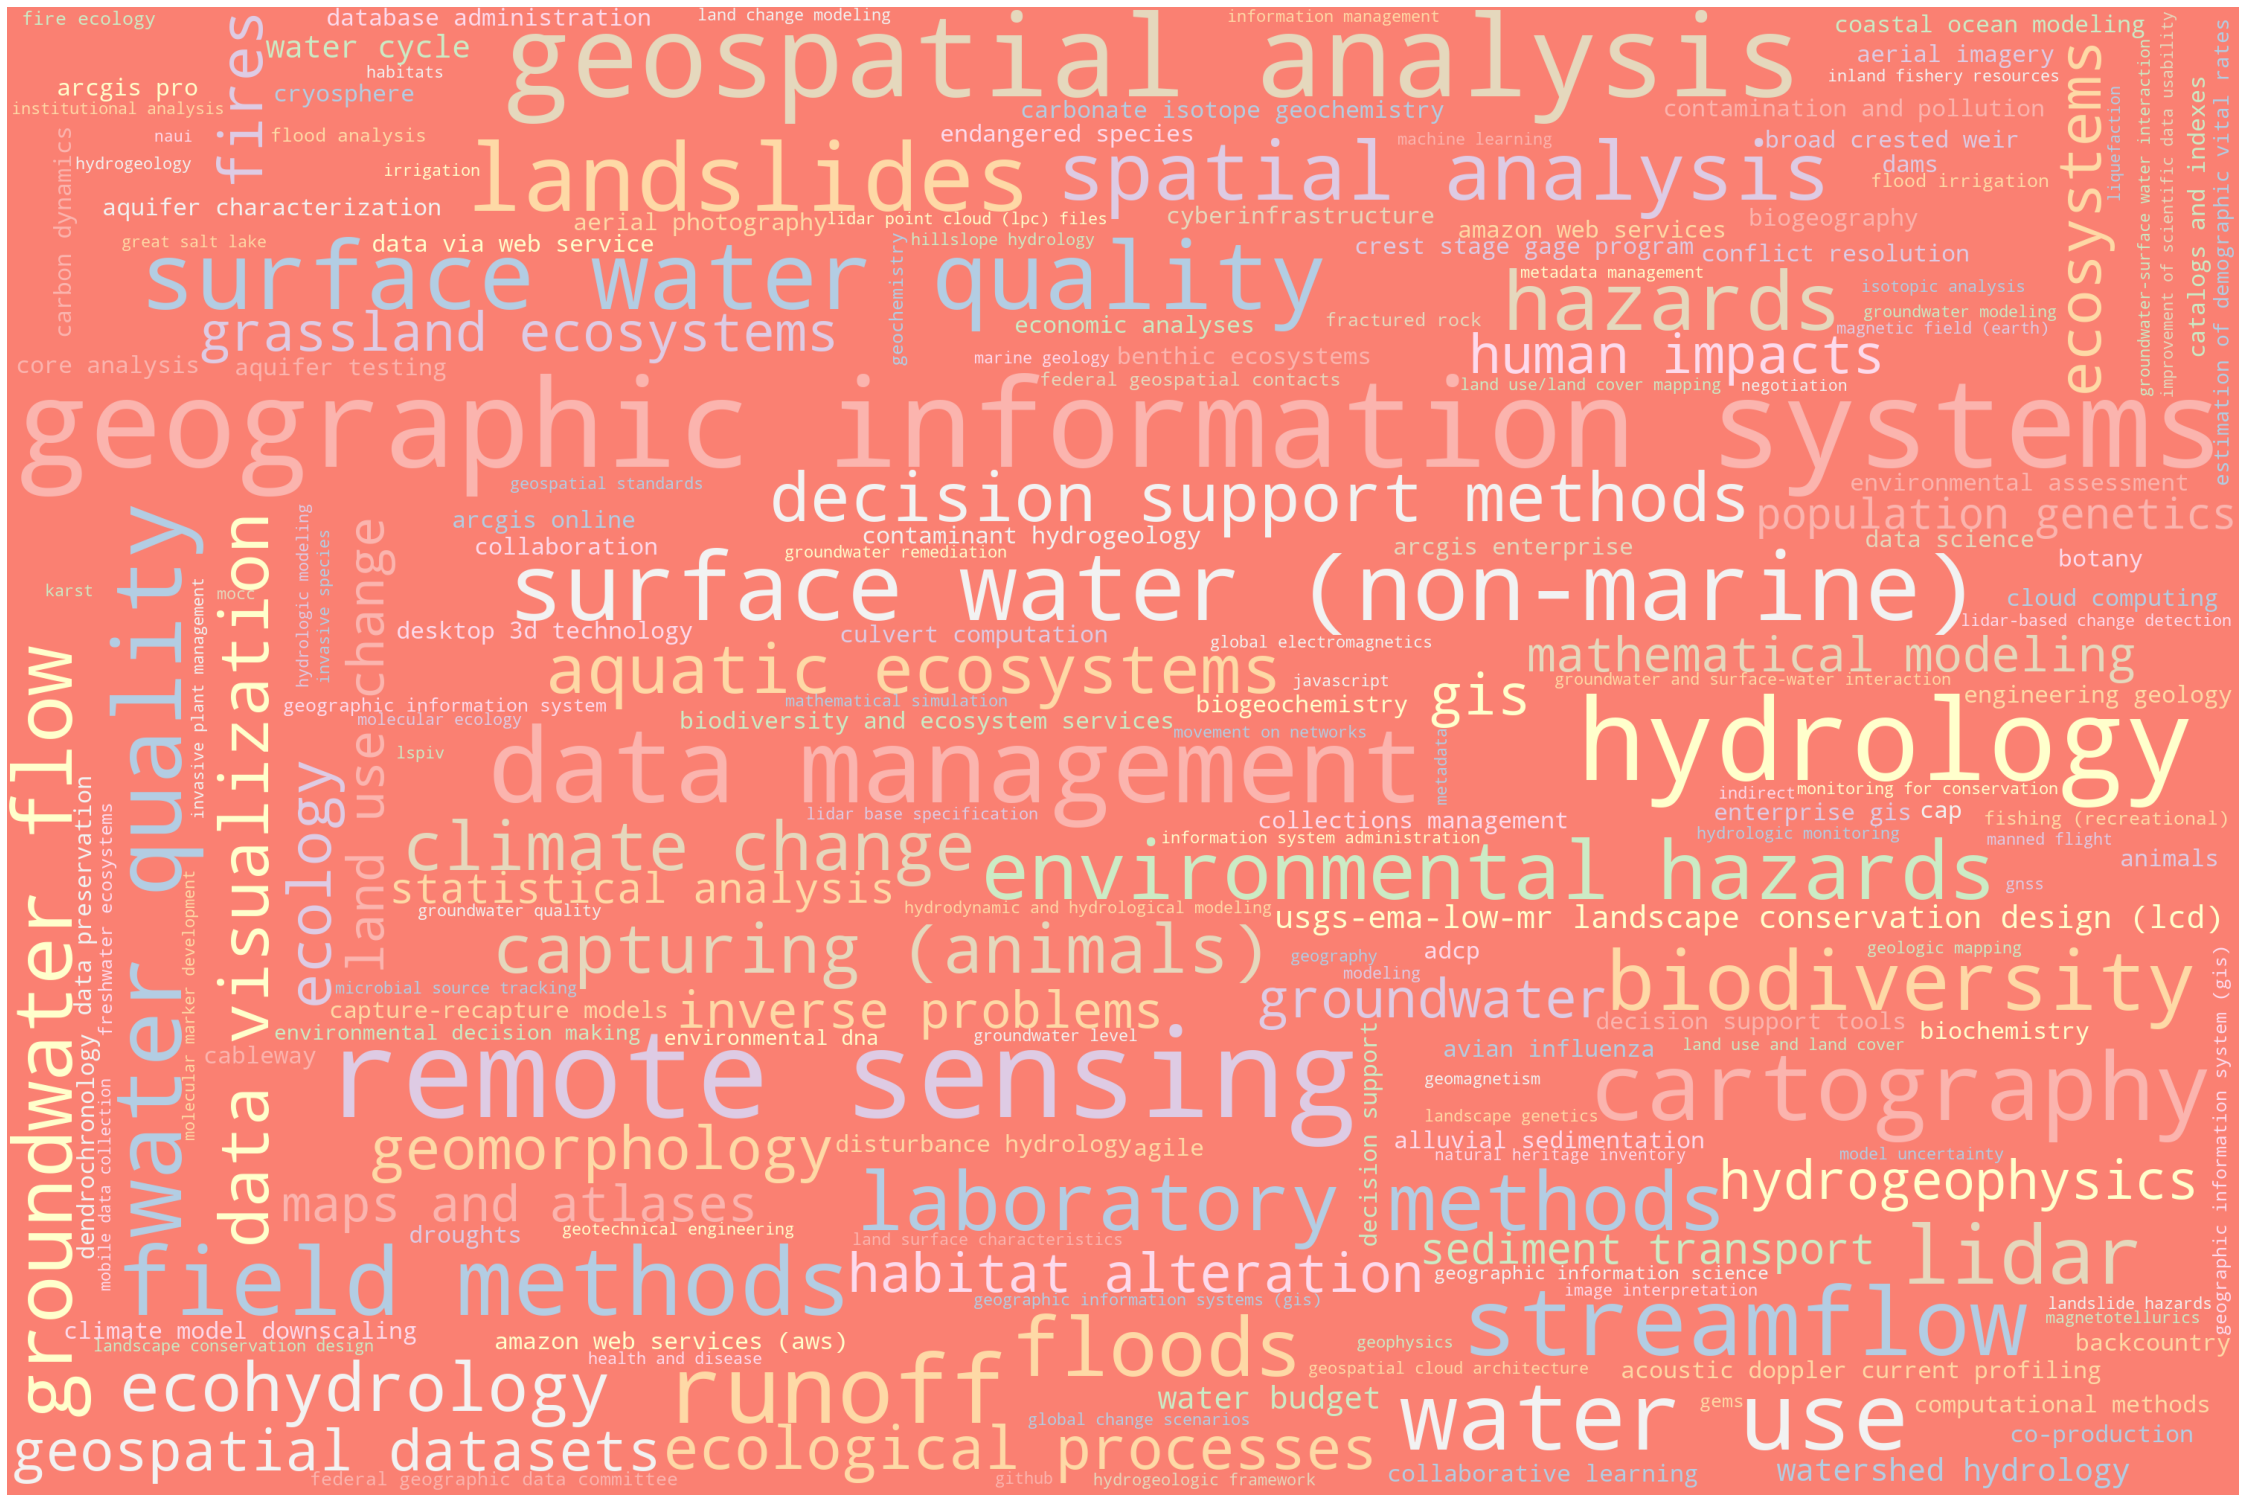

In [7]:
wordcloud_all_terms = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate_from_frequencies(Counter(all_terms))

plot_cloud(wordcloud_all_terms)

## Non-thesaurus terms
This word cloud looks the frequency of that were supplied by users but that could not yet be aligned with the USGS Thesaurus.

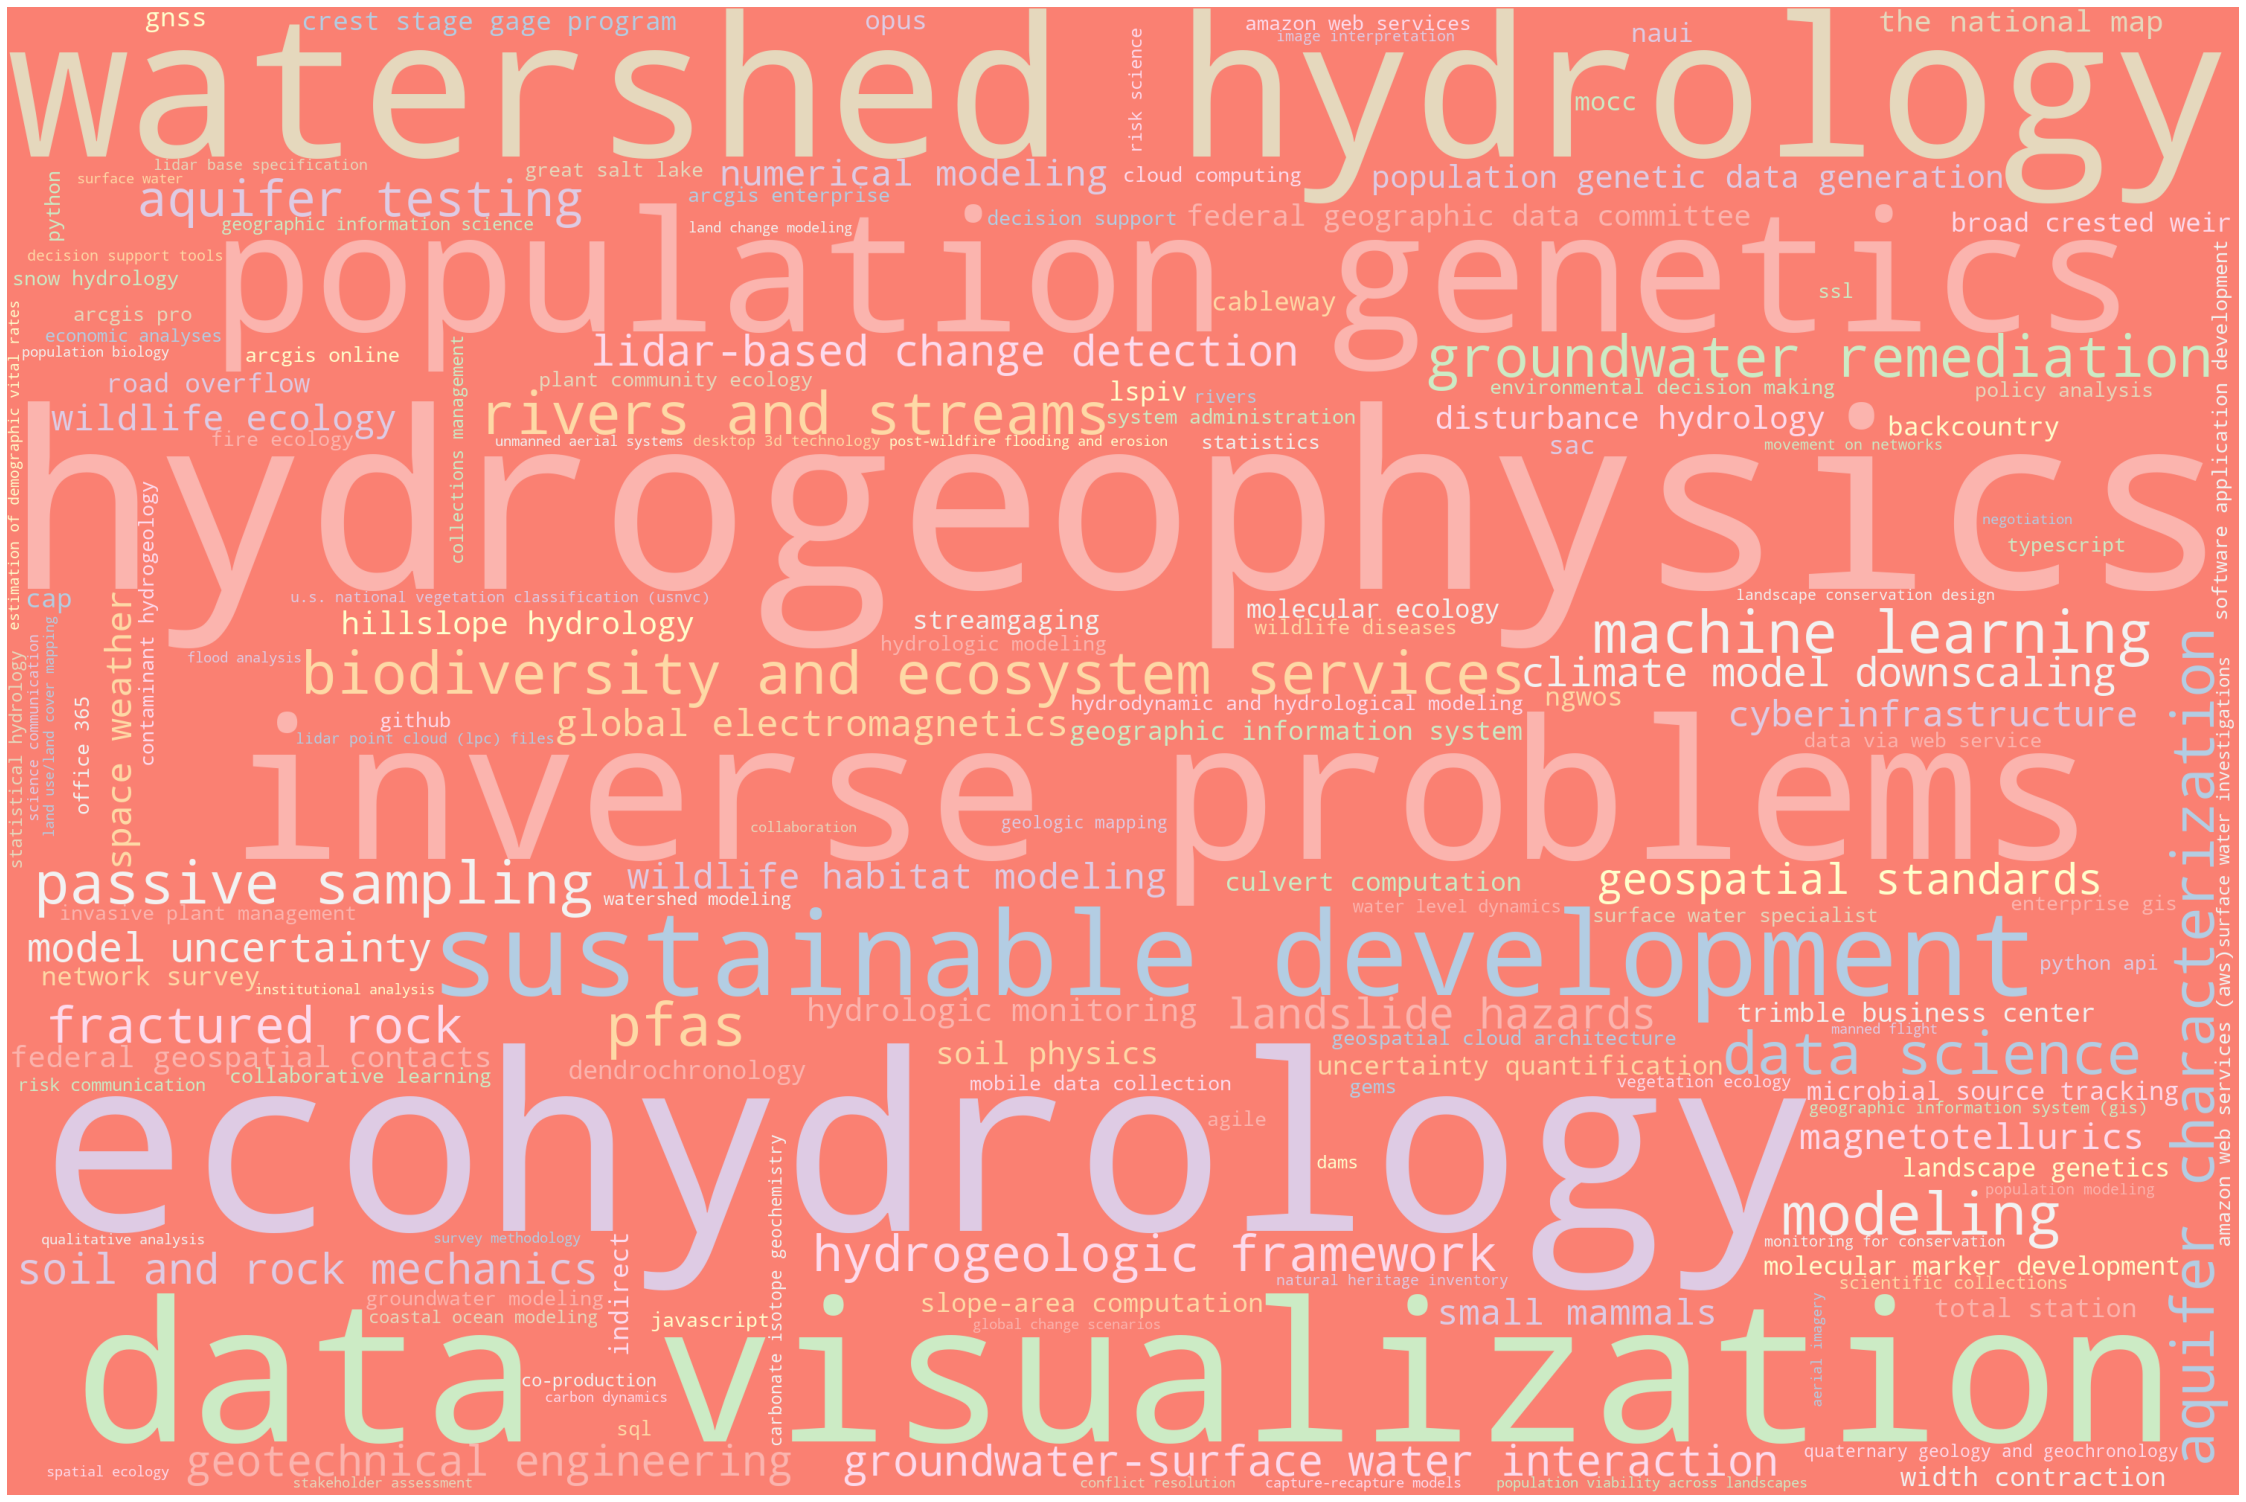

In [8]:
wordcloud_non_thesaurus = WordCloud(
    width = 3000, 
    height = 2000, 
    random_state=1, 
    background_color='salmon', 
    colormap='Pastel1', 
    collocations=False, 
    stopwords = STOPWORDS
).generate_from_frequencies(Counter(non_thesaurus_terms))

plot_cloud(wordcloud_non_thesaurus)

## Shared Expertise
This listing looks at all of the terms where there is more than one assertion of this as expertise across the corpus of CDI members and their Staff Profiles. It shows the term (corrected to lower case), the count, and lists the links to staff profile pages with these claims. This provides an interesting look at where there may be synergistic interests across the CDI community.

In [9]:
for item in shared_expertise:
    print(item[0], "----", item[1])
    for profile_url in [p["profile"] for p in profile_expertise if item[0] in p["all_terms"]]:
        print(profile_url)
    print("========")

aquatic ecosystems ---- 2
https://usgs.gov/staff-profiles/abigail-j-lynch
https://usgs.gov/staff-profiles/muruleedhara-byappanahalli
biodiversity ---- 3
https://www.usgs.gov/staff-profiles/annie-simpson
https://usgs.gov/staff-profiles/alexa-j-mckerrow
https://usgs.gov/staff-profiles/amy-symstad
capturing (animals) ---- 2
https://usgs.gov/staff-profiles/charlie-besteder
https://usgs.gov/staff-profiles/brian-halstead
cartography ---- 4
https://usgs.gov/staff-profiles/christy-ann-m-archuleta
https://usgs.gov/staff-profiles/brigitta-urban-mathieux
https://usgs.gov/staff-profiles/aaron-j-stephenson
https://usgs.gov/staff-profiles/ariel-doumbouya
climate change ---- 2
https://usgs.gov/staff-profiles/abigail-j-lynch
https://usgs.gov/staff-profiles/adam-terando
data management ---- 5
https://www.usgs.gov/staff-profiles/annie-simpson
https://usgs.gov/staff-profiles/amber-wittner
https://usgs.gov/staff-profiles/aaron-j-stephenson
https://usgs.gov/staff-profiles/andrew-e-lamotte
https://usgs.gov/

## Shared Profiles
Another interesting possibility is to look for cases where one person "connects" to any other person through one or more shared expertise terms. I'll eventually build this out into a proper graph, but the following list intersection view shows the basic idea.

In [10]:
shared_profiles = list()
for profile in profile_expertise:
    this_profile_expertise = profile["all_terms"]
    for op in [p for p in profile_expertise if p["profile"] != profile["profile"]]:
        common_expertise = list(filter(lambda x:x in this_profile_expertise, op["all_terms"]))
        if len(common_expertise) > 0:
            shared_profiles.append((
                profile["profile"],
                common_expertise,
                op["profile"]
            ))
shared_profiles

[('https://usgs.gov/staff-profiles/abigail-j-lynch',
  ['aquatic ecosystems'],
  'https://usgs.gov/staff-profiles/muruleedhara-byappanahalli'),
 ('https://usgs.gov/staff-profiles/abigail-j-lynch',
  ['climate change'],
  'https://usgs.gov/staff-profiles/adam-terando'),
 ('https://usgs.gov/staff-profiles/alison-appling',
  ['mathematical modeling'],
  'https://usgs.gov/staff-profiles/brian-a-ebel'),
 ('https://usgs.gov/staff-profiles/alison-appling',
  ['ecology'],
  'https://usgs.gov/staff-profiles/benjamin-h-letcher'),
 ('https://usgs.gov/staff-profiles/alex-r-fiore',
  ['landslides'],
  'https://usgs.gov/staff-profiles/ben-mirus'),
 ('https://usgs.gov/staff-profiles/alex-r-fiore',
  ['hydrogeophysics'],
  'https://usgs.gov/staff-profiles/burke-minsley'),
 ('https://usgs.gov/staff-profiles/alex-r-fiore',
  ['landslides'],
  'https://usgs.gov/staff-profiles/alex-grant'),
 ('https://usgs.gov/staff-profiles/alex-r-fiore',
  ['landslides', 'groundwater flow'],
  'https://usgs.gov/staff-pr

## Unique Expertise
We can also look at cases where CDI members appear to possibly have unique expertise based on terms they've selected different from anyone else in the community. As messy (uncontrolled) as the process is behind this exercise, we should take any of this with a grain of salt. I previously built this as an inverse to the shared expertise list.

In [11]:
unique_expertise.sort()
unique_expertise

['adcp',
 'aerial imagery',
 'aerial photography',
 'agile',
 'amazon web services',
 'amazon web services (aws)',
 'animals',
 'aquifer characterization',
 'aquifer testing',
 'arcgis enterprise',
 'arcgis online',
 'arcgis pro',
 'avian influenza',
 'backcountry',
 'benthic ecosystems',
 'biodiversity and ecosystem services',
 'biogeochemistry',
 'biogeography',
 'botany',
 'broad crested weir',
 'cableway',
 'cap',
 'capture-recapture models',
 'capturing (animals)',
 'carbon dynamics',
 'carbonate isotope geochemistry',
 'climate model downscaling',
 'cloud computing',
 'co-production',
 'coastal ocean modeling',
 'collaboration',
 'collaborative learning',
 'collections management',
 'computational methods',
 'conflict resolution',
 'contaminant hydrogeology',
 'contamination and pollution',
 'core analysis',
 'crest stage gage program',
 'cryosphere',
 'culvert computation',
 'cyberinfrastructure',
 'dams',
 'data preservation',
 'data science',
 'data via web service',
 'databas

## Cleaning up terms
Looking at all of our term lists, we can see that there are some things that probably make sense to consider expansion in the USGS Thesaurus or extension into other vocabulary/ontology sources. We might also look to do some simple internal harmonization in the "Expertise Dashboard" system, encouraging staff to align with terms already supplied by other users if they are simple enough or specialized enough to assume equivalency between the concepts. The following check uses cosine similarity between the terms not yet aligned with the USGS Thesaurus and all other terms to see if there are some things that are probably closely enough aligned that they could be harmonized. The issue, of course, is that they have to be harmonized to something, and it would be better if we had a larger reference source in terms an ontology that mapped concepts to the overall idea of things that would describe expertise.

In [12]:
for term in non_thesaurus_terms:
    similar = similar_terms(term, list(set(all_terms)))
    if len(similar) > 0:
        print(term, similar)

biodiversity and ecosystem services ['biodiversity']
rivers and streams ['rivers']
data science ['science communication', 'risk science']
modeling ['watershed modeling', 'mathematical modeling', 'numerical modeling', 'groundwater modeling', 'hydrologic modeling', 'land change modeling', 'population modeling']
groundwater remediation ['groundwater']
groundwater-surface water interaction ['groundwater and surface-water interaction', 'surface water']
landslide hazards ['hazards']
watershed hydrology ['hydrology', 'watershed modeling']
numerical modeling ['modeling']
wildlife ecology ['wildlife', 'ecology']
wildlife habitat modeling ['wildlife']
hillslope hydrology ['hydrology']
disturbance hydrology ['hydrology']
hydrologic monitoring ['hydrologic modeling']
geographic information system ['information system administration', 'geographic information science', 'geographic information systems (gis)', 'geographic information systems', 'geographic information system (gis)']
landscape genetics 